In [19]:
! pip install datasets

In [20]:
from datasets import list_datasets

In [21]:
datasets = list_datasets()

In [22]:
metadata = list_datasets(with_details=True)[datasets.index("emotion")]

In [23]:
metadata

datasets.ObjectInfo(
	id='emotion',
	description='Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper.',
	files=None
)

In [24]:
from datasets import load_dataset

In [25]:
emotion = load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/home/.cache/huggingface/datasets/emotion/default/0.0.0/6e4212efe64fd33728549b8f0435c73081391d543b596a05936857df98acb681)


In [26]:
emotion['train'].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None)}

In [27]:
train_ds=emotion['train']

In [28]:
train_ds[:5]

{'label': [0, 0, 3, 2, 3],
 'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy']}

In [29]:
import pandas as pd

In [30]:
emotion.set_format(type='pandas')

In [31]:
df = emotion['train'][:]

In [32]:
df.columns

Index(['label', 'text'], dtype='object')

In [33]:
def label_int2str(row,split):
    return emotion[split].features["label"].int2str(row)

In [34]:
df["label_name"] = df["label"].apply(label_int2str, split="train")

In [35]:
df.head()

,label,text,label_name
0,0,i didnt feel humiliated,sadness
1,0,i can go from feeling so hopeless to so damned...,sadness
2,3,im grabbing a minute to post i feel greedy wrong,anger
3,2,i am ever feeling nostalgic about the fireplac...,love
4,3,i am feeling grouchy,anger


In [36]:
import matplotlib.pyplot as plt

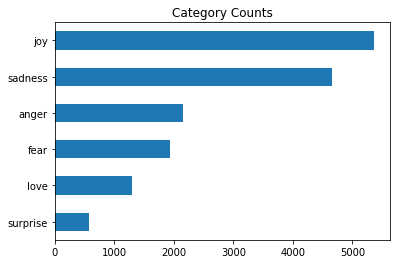

In [37]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts");

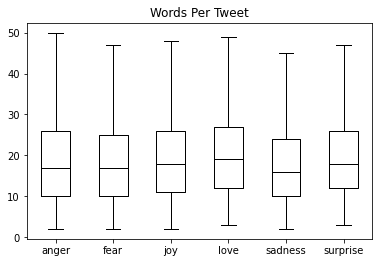

In [38]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by='label_name', grid=False, showfliers=False,
           color='black', )
plt.suptitle("")
plt.xlabel("");

In [38]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [39]:
tokenizer.vocab_size

30522

In [40]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [41]:
tokenizer.model_max_length

512

In [42]:
encoded_str = tokenizer.encode("this is a complicatedtest")
encoded_str

[101, 2023, 2003, 1037, 8552, 22199, 102]

In [43]:
for token in encoded_str:
    print(token, tokenizer.decode([token]))

101 [CLS]
2023 this
2003 is
1037 a
8552 complicated
22199 ##test
102 [SEP]


In [44]:
from transformers import AutoModel
import torch

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
text = "this is a test"
text_tensor = tokenizer.encode(text, return_tensors="pt").to(device)

In [47]:
text_tensor.shape

torch.Size([1, 6])

In [48]:
output = model(text_tensor)
output.last_hidden_state.shape

torch.Size([1, 6, 768])

In [49]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [50]:
emotion.reset_format()

In [51]:
emotions_encoded = emotion.map(tokenize, batched=True, batch_size=None)

In [52]:
import numpy as np

In [53]:
def forward_pass(batch):
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)
    with torch.no_grad():
        last_hidden_state = model(input_ids, attention_mask).last_hidden_state
        last_hidden_state = last_hidden_state.cpu().numpy()
    lhs_shape = last_hidden_state.shape
    boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
    boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
    boolean_mask = boolean_mask.reshape(lhs_shape)
    masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
    batch["hidden_state"] = masked_mean.data
    return batch

In [54]:
emotions_encoded = emotions_encoded.map(forward_pass, batched=True,
                                        batch_size=16)

In [55]:
from transformers import AutoModelForSequenceClassification

In [56]:
num_labels = 6

In [57]:
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_labels).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

In [58]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [81]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [82]:
from transformers import Trainer, TrainingArguments

In [83]:
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(output_dir="results",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,)

In [84]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"])
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.834100,0.314119,0.907500,0.905412
2,0.250600,0.223625,0.919500,0.919913


In [85]:
results = trainer.evaluate()
results

{'eval_loss': 0.22362545132637024,
 'eval_accuracy': 0.9195,
 'eval_f1': 0.919912635541955,
 'eval_runtime': 5.2297,
 'eval_samples_per_second': 382.434,
 'epoch': 2.0,
 'eval_mem_cpu_alloc_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 149893120}

In [62]:
train_subset = emotions_encoded["train"].shard(index=1, num_shards=10)
eval_subset = emotions_encoded["validation"].shard(index=1, num_shards=10)

In [64]:
len(eval_subset)

200

In [89]:
! pip install optuna -q

In [90]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=num_labels)

In [91]:
trainer = Trainer(model_init=model_init, args=training_args,
                  compute_metrics=compute_metrics, train_dataset=train_subset,
                  eval_dataset=eval_subset)
best_run = trainer.hyperparameter_search(n_trials=3, direction="maximize")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.049557,0.625000,0.532991
2,No log,0.707563,0.705000,0.679574
3,No log,0.481037,0.840000,0.833401


[I 2021-05-22 13:23:36,816] Trial 0 finished with value: 1.6734012099012099 and parameters: {'learning_rate': 5.9964458741796154e-05, 'num_train_epochs': 3, 'seed': 30, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 1.6734012099012099.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model f

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.693561,0.380000,0.304342
2,No log,1.600984,0.495000,0.385000
3,No log,1.562345,0.505000,0.392917
4,No log,1.552465,0.510000,0.396674


[I 2021-05-22 13:24:23,927] Trial 1 finished with value: 0.9066735528820837 and parameters: {'learning_rate': 2.565901272926517e-06, 'num_train_epochs': 4, 'seed': 13, 'per_device_train_batch_size': 32}. Best is trial 0 with value: 1.6734012099012099.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model fr

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.559986,0.440000,0.349294
2,1.641900,1.482976,0.530000,0.417138
3,1.508600,1.444719,0.530000,0.419552


[I 2021-05-22 13:25:27,440] Trial 2 finished with value: 0.9495521719659651 and parameters: {'learning_rate': 2.8666750798879056e-06, 'num_train_epochs': 3, 'seed': 4, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 1.6734012099012099.


In [92]:
for key, value in best_run.hyperparameters.items():
    setattr(trainer.args, key, value)

trainer.train_dataset = emotions_encoded["train"]
trainer.eval_dataset = emotions_encoded["validation"]
trainer.train();

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.234500,0.179138,0.928500,0.927879
2,0.127200,0.144719,0.935500,0.935844
3,0.079200,0.144869,0.937000,0.936854


In [93]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [94]:
preds_output.metrics

{'test_loss': 0.144868865609169,
 'test_accuracy': 0.937,
 'test_f1': 0.9368540951748976,
 'test_runtime': 5.3607,
 'test_samples_per_second': 373.088,
 'test_mem_cpu_alloc_delta': 221184,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 0,
 'test_mem_gpu_peaked_delta': 149958656}

In [95]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [114]:
y_preds[0:10]

array([0, 0, 2, 3, 1, 1, 1, 1, 1, 0])

In [117]:
emotions_encoded['validation']['label'][0:10]

tensor([0, 0, 2, 3, 1, 1, 1, 1, 1, 0])

In [104]:
labels=emotion["train"].features["label"].names

In [106]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [118]:
import numpy as np
from sklearn.metrics import confusion_matrix
x, y = np.meshgrid(range(0, 3), range(0, 3))
cm = confusion_matrix(y_preds, emotions_encoded['validation']['label'], labels=[0, 1, 2,3,4,5])

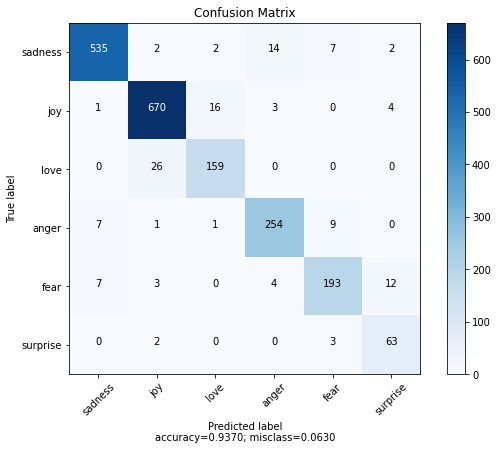

In [119]:
plot_confusion_matrix(cm           = cm,
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_preds, emotions_encoded['validation']['label'], target_names=labels))

              precision    recall  f1-score   support

     sadness       0.97      0.95      0.96       562
         joy       0.95      0.97      0.96       694
        love       0.89      0.86      0.88       185
       anger       0.92      0.93      0.93       272
        fear       0.91      0.88      0.90       219
    surprise       0.78      0.93      0.85        68

    accuracy                           0.94      2000
   macro avg       0.90      0.92      0.91      2000
weighted avg       0.94      0.94      0.94      2000



In [122]:
custom_tweet = "i saw a movie today and it was really good."
input_tensor = tokenizer.encode(custom_tweet, return_tensors="pt").to("cuda")
logits = model(input_tensor).logits

In [123]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [124]:
probs

array([0.01072309, 0.9686637 , 0.00845045, 0.00519019, 0.00324921,
       0.00372339], dtype=float32)